# Enrichment Analysis on LCI Predictions

Analyzes the enrichment of proteins predicted by LCI

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import json
import pickle

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy


from dpp.methods.lci.lci_method import LCIModule
from dpp.experiments.go_enrichment import GOEnrichment
from dpp.data.network import PPINetwork
from dpp.util import Params, prepare_sns, load_mapping
from dpp.data.associations import load_diseases
# os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")
os.chdir("/dfs/scratch0/sabri/disease-protein-prediction")
prepare_sns(sns, {})

## Loading Data
Load disease associations and protein-protein interaction network.

In [2]:
# load diseases
diseases_dict = load_diseases("data/associations/disgenet-associations.csv", exclude_splits=['none'])

In [3]:
# load network
network = PPINetwork("data/networks/bio-pathways-network.txt")
n = len(network)

In [6]:
# load entrez mapping
symbol_to_entrez = load_mapping("data/protein/symbol_to_entrez.txt", "\t")
entrez_to_symbol = {int(entrez): symbol for symbol, entrez in symbol_to_entrez.items() if entrez!=""}

## Load Predictions
Load predictions from a disease protein prediction method.

In [7]:
preds_df = pd.read_csv("experiments/dpp_predict/lci/predictions.csv", index_col=0)

## Load Evaluation

In [9]:
eval_df = pd.read_csv("experiments/aggregation/results.csv", header=[0, 1], index_col=0)

## Load Enrichment Analysis
Prepare an enrichment study

In [ ]:
# load gene ontology
obodag = GODag("../data/go/go-basic.obo")

In [ ]:
geneid2go = read_ncbi_gene2go("../data/go/gene2go.txt", taxids=[9606])

In [ ]:
goeaobj = GOEnrichmentStudy(network.get_proteins(), # List of mouse protein-coding genes
                            geneid2go, # geneid/GO associations
                            obodag, # Ontologies
                            propagate_counts = True,
                            alpha = 0.05, # default significance cut-off
                            methods = ['fdr_bh']) # defult multipletest correction method

## Perform Enrichment Analysis
Perform an enrichment analysis on one disease. 

In [225]:
disease_id = "C0398623"
disease_proteins = set(diseases_dict[disease_id].proteins)
disease_symbols = [entrez_to_symbol[entrez] for entrez in disease_proteins if entrez in entrez_to_symbol]
symbols_str=str(disease_symbols).replace('\'', '')
print(f"{diseases_dict[disease_id].name}: {symbols_str}")
sorted_predictions = predictions.loc[disease_id].sort_values(ascending=False).index
print_list([entrez_to_symbol[int(entrez)] for entrez in sorted_predictions[:7] if int(entrez) in entrez_to_symbol])

Thrombophilia: [FGA, MYD88, HRG, PLAT, THBD, HABP2, SERPINA10, PIGA, F2, F5, MTHFR, F8, F9, SERPIND1, PROC, PROS1]
(1) PROZ, (2) F2RL3, (3) GP5, (4) SERPINA5, (5) F11, (6) SERPINB6, (7) GGCX


In [216]:
# run disease enrichment
disease_results = goeaobj.run_study(disease_proteins)

100%     12 of     12 study items found in association
100%     12 of     12 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
   1,212 GO terms are associated with     12 of     12 study items
     218 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [212]:
# run prediction enrichment
pred_proteins = set(map(int, sorted_predictions[:len(disease_proteins)]))
pred_results = goeaobj.run_study(pred_proteins)

(1) IL20RA, (2) NLRP2, (3) ATM, (4) LSP1, (5) MRE11
 93%     14 of     15 study items found in association
100%     15 of     15 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
     952 GO terms are associated with     14 of     15 study items
     179 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [206]:
def print_list(term_list):
    string = ""
    for i, term in enumerate(term_list):
        string += f"({i+1}) {term}, "
    print(string[:-2])

In [207]:
k = 5
disease_top_k = sorted(disease_results, key=lambda x: x.p_fdr_bh)[:k]
disease_significant = [r for r in disease_results if r.p_fdr_bh < 0.05]
print_list([result.goterm.name for result in disease_top_k])
pred_top_k = sorted(pred_results, key=lambda x: x.p_fdr_bh)[:k]
pred_significant = [r for r in pred_results if r.p_fdr_bh < 0.05]
print_list([result.goterm.name for result in pred_top_k])

(1) double-strand break repair, (2) cellular response to DNA damage stimulus, (3) DNA repair, (4) DNA metabolic process, (5) double-strand break repair via homologous recombination
(1) DNA repair, (2) DNA integrity checkpoint, (3) chromosome organization, (4) telomere maintenance, (5) positive regulation of DNA metabolic process


In [208]:
intersection = set([result.goterm.name for result in disease_top_k]) & set([result.goterm.name for result in pred_top_k])
union = set([result.goterm.name for result in disease_top_k]) | set([result.goterm.name for result in pred_top_k])
print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.1111111111111111


In [209]:
intersection = set([result.goterm.name for result in pred_significant]) & set([result.goterm.name for result in disease_significant])
union = set([result.goterm.name for result in pred_significant]) | set([result.goterm.name for result in disease_significant])

print("Jaccard Similarity: {}".format(1.0*len(intersection)/len(union)))

Jaccard Similarity: 0.36981132075471695


## Load Enrichment Results
Load enrichment study results

In [29]:
lci_results = pd.read_csv("experiments/go_enrichment/lci/results.csv", index_col=0)
rw_results = pd.read_csv("experiments/go_enrichment/random_walk/results.csv", index_col=0)

In [31]:
lci_eval_results = pd.read_csv("experiments/dpp_evaluate/lci/metrics.csv", index_col=0)

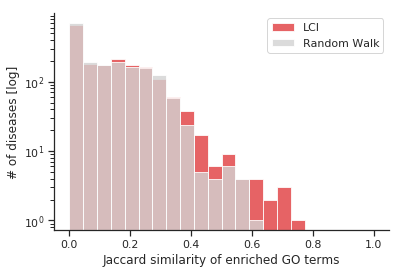

In [228]:
sns.distplot(lci_results["lci_jaccard_sim"], bins=22, kde=False, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(rw_results["lci_jaccard_sim"], bins=22, kde=False, label="Random Walk", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('log')
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("# of diseases [log]")
plt.legend()
plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

In [34]:
np.median(lci_results["lci_jaccard_sim"])

0.11055276381909547

In [35]:
np.median(rw_results["lci_jaccard_sim"])

0.09216589861751152

In [26]:
lci_jaccard = lci_results["lci_jaccard_sim"].sort_index()

In [27]:
lci_dpp = lci_eval_results["Recall-at-100"].sort_index()

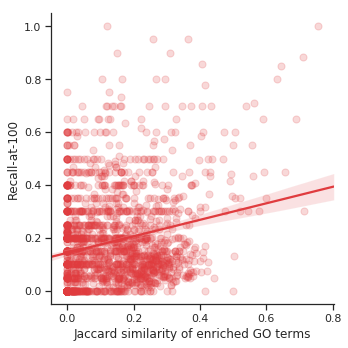

In [229]:
sns.lmplot(x='lci_jaccard_sim', y='Recall-at-100', data=pd.concat([lci_jaccard, lci_dpp], axis=1), scatter_kws={"s": 50, "alpha": 0.2})
plt.xlabel("Jaccard similarity of enriched GO terms")
plt.ylabel("Recall-at-100")



pearsonr(lci_jaccard, lci_dpp)
plt.savefig("../experiments/go_enrichment/lci/jaccard_recall_go.pdf")

## Metric Exploration

In [12]:
experiment_dir = 'experiments/go_enrichment/precompute'

In [14]:
outputs_path = os.path.join(experiment_dir, "outputs.pkl")
if os.path.exists(outputs_path):
    with open(outputs_path, 'rb') as f:
        outputs = pickle.load(f)

In [15]:
outputs["C0013182"].keys()

dict_keys(['disease', 'lci', 'random_walk'])

In [16]:
def get_significant_terms(output, threshold=0.05):
    """
    """
    terms, pvalues = list(zip(*output.items()))
    significant_idxs = np.where(np.array(pvalues) < threshold)
    return np.array(terms)[significant_idxs]

### Jaccard

In [44]:
def jaccard(a_terms, b_terms):
    """
    """
    a_terms = set(a_terms)
    b_terms = set(b_terms)
    return (len(a_terms & b_terms) / len(a_terms | b_terms) if len(a_terms | b_terms) != 0 else 0)

In [45]:
output = outputs["C0013182"]

jaccard_results = {}
for disease_id, output in tqdm(outputs.items()):
    disease_terms = get_significant_terms(output["disease"], threshold=0.01)
    lci_terms = get_significant_terms(output["lci"], threshold=0.01)
    rw_terms = get_significant_terms(output["random_walk"], threshold=0.01)
    lci_jaccard = jaccard(disease_terms, lci_terms)
    rw_jaccard = jaccard(disease_terms, rw_terms)
    jaccard_results[disease_id] = {
        "lci": lci_jaccard,
        "rw": rw_jaccard
    }

100%|██████████| 1811/1811 [03:55<00:00,  7.70it/s]


In [54]:
jaccard_df = pd.DataFrame(list(jaccard_results.values()), index=list(jaccard_results.keys()))

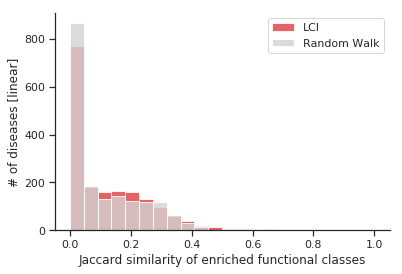

In [56]:
sns.distplot(jaccard_df["lci"], bins=22, kde=False, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(jaccard_df["rw"], bins=22, kde=False, label="Random Walk", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel("Jaccard similarity of enriched functional classes")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

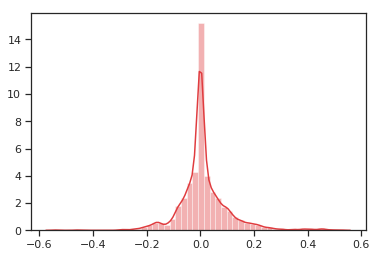

In [80]:
sns.distplot(jaccard_df["lci"] - jaccard_df["rw"])

### Spearman

In [17]:
from scipy.stats import spearmanr
 
def compute_spearman_correlation(a_term_to_pval, b_term_to_pval):
        """
        """
        terms = list(a_term_to_pval.keys())
        sp_corr, sp_pval = spearmanr([a_term_to_pval[term] for term in terms],
                                     [b_term_to_pval[term] for term in terms])
        return sp_corr, sp_pval

In [18]:
spearman_results = {}
for disease_id, output in tqdm(outputs.items()):
    lci_spearman, _ = compute_spearman_correlation(output["disease"], output["lci"])
    rw_spearman, _ = compute_spearman_correlation(output["disease"], output["random_walk"])
    spearman_results[disease_id] = {
        "lci": lci_spearman,
        "rw": rw_spearman
    }

  2%|▏         | 45/1811 [00:01<00:43, 40.91it/s]/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid va

In [48]:
spearman_df = pd.DataFrame(list(spearman_results.values()), index=list(spearman_results.keys()))
spearman_df.mean()

lci    0.246626
rw     0.224271
dtype: float64

/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


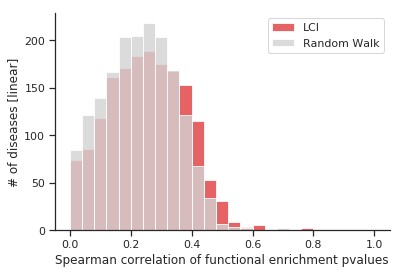

In [20]:
sns.distplot(spearman_df["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={"range": (0, 1),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0, 1),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel("Spearman correlation of functional enrichment pvalues")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

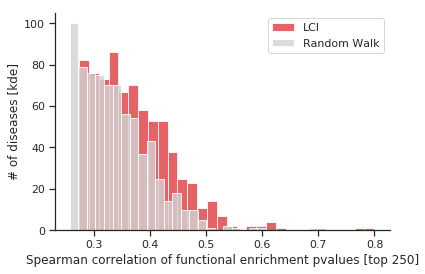

In [87]:
sns.distplot(spearman_df["lci"].nlargest(750), bins=30, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df["rw"].nlargest(750), bins=30, kde=False, hist=True, label="Random Walk", hist_kws={
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel("Spearman correlation of functional enrichment pvalues [top 250]")
plt.ylabel("# of diseases [kde]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

#### Top by Mean Correlation

In [21]:
spearman_mean_df = spearman_df[['lci', 'rw']].mean(axis=1)
spearman_df.insert(0, column="mean", value=spearman_mean_df)

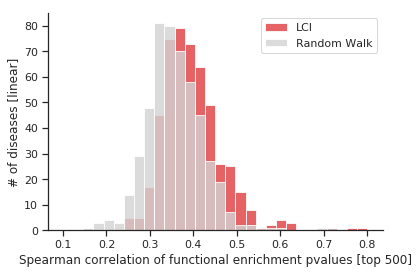

In [22]:
top_k = 500
sns.distplot(spearman_df.nlargest(top_k, "mean")["lci"], bins=30, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "range": (0.1, 0.8),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df.nlargest(top_k, "mean")["rw"], bins=30, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0.1, 0.8),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel(f"Spearman correlation of functional enrichment pvalues [top {top_k}]")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

### Top by LCI

In [36]:
eval_df["lci_dpp[DP]", "Recall-at-100"]
spearman_df.insert(0, column="lci_recall_100", value=eval_df["lci_dpp[DP]", "Recall-at-100"])

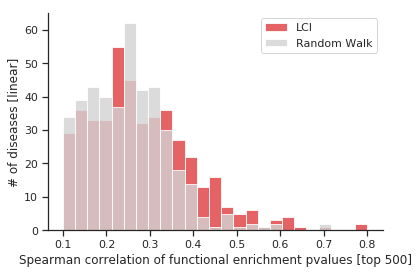

In [44]:
top_k = 500
sns.distplot(spearman_df.nlargest(top_k, "lci_recall_100")["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "range": (0.1, 0.8),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df.nlargest(top_k, "lci_recall_100")["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0.1, 0.8),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel(f"Spearman correlation of functional enrichment pvalues [top {top_k}]")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

### Top by RW

In [38]:
eval_df["lci_dpp[DP]", "Recall-at-100"]
spearman_df.insert(0, column="rw_recall_100", value=eval_df["rw_dpp[DP]", "Recall-at-100"])

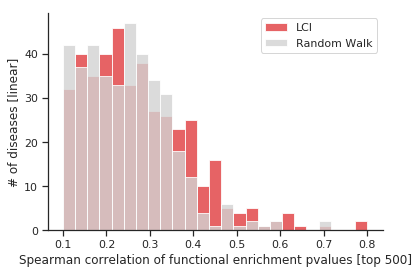

In [45]:
top_k = 500
sns.distplot(spearman_df.nlargest(top_k, "rw_recall_100")["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "range": (0.1, 0.8),
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(spearman_df.nlargest(top_k, "rw_recall_100")["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={"range": (0.1, 0.8),
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel(f"Spearman correlation of functional enrichment pvalues [top {top_k}]")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

### Pearson

In [109]:
from scipy.stats import pearsonr
 
def compute_pearson_correlation(a_term_to_pval, b_term_to_pval):
        """
        """
        terms = list(a_term_to_pval.keys())
        sp_corr, sp_pval = pearsonr([a_term_to_pval[term] for term in terms],
                                    [b_term_to_pval[term] for term in terms])
        return sp_corr, sp_pval

In [110]:
pearson_results = {}
for disease_id, output in tqdm(outputs.items()):
    lci_pearson, _ = compute_pearson_correlation(output["disease"], output["lci"])
    rw_pearson, _ = compute_pearson_correlation(output["disease"], output["random_walk"])
    pearson_results[disease_id] = {
        "lci": lci_pearson,
        "rw": rw_pearson
    }
    

100%|██████████| 1811/1811 [00:58<00:00, 39.14it/s]


In [69]:
pearson_df = pd.DataFrame(list(spearman_results.values()), index=list(spearman_results.keys())).join(size_df)

/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/dfs/scratch0/sabri/disease-protein-prediction/env/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


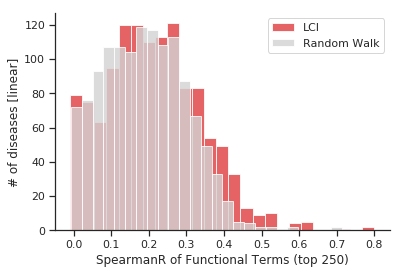

In [80]:
sns.distplot(pearson_df.sort_values('size').head(-500)["lci"], bins=25, kde=False, hist=True, label="LCI", hist_kws={
                                                                                        "color": "#E03C3F",
                                                                                        "alpha":0.8})
sns.distplot(pearson_df.sort_values('size').head(-500)["rw"], bins=25, kde=False, hist=True, label="Random Walk", hist_kws={
                                                                                      "color": "lightgrey",
                                                                                      "alpha": 0.8})
sns.despine()
plt.yscale('linear')
plt.xlabel("SpearmanR of Functional Terms (top 250)")
plt.ylabel("# of diseases [linear]")
plt.legend()
#plt.savefig("../experiments/go_enrichment/lci/lci_rw_go.pdf")

In [117]:
np.mean(pearson_df["lci"])

0.24662556342597527

In [118]:
np.mean(pearson_df["rw"])

0.22427117693116

### Disease Size Analysis

In [39]:
size_dict = {disease.id: len(disease) for disease in diseases_dict.values()}
size_df = pd.DataFrame(size_dict.values(), index=size_dict.keys(), columns=["size"])

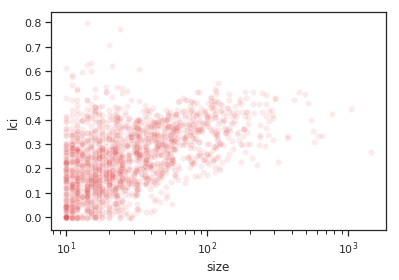

In [119]:
sns.scatterplot(data=spearman_df.join(size_df), x="size", y="lci", alpha=0.1)
plt.xscale('log')